In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import datetime
import feather

import warnings
warnings.filterwarnings('ignore')

# plotting
import pylab
import matplotlib.pylab as plt
# add some nice background for maps
import contextily as ctx
# geo imports
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj
import shapely

from fuzzywuzzy import fuzz

shapely.speedups.enable()

pd.set_option('display.max_columns', None)  

%matplotlib inline
%load_ext autoreload
%autoreload 2


### Base location file: Parcels

In [2]:
# convert to geopandas 
gf = gpd.read_file("Detroit Parcels/geo_export_b5018d7d-5276-4925-9cb3-1bbf74026fde.shp")
display(gf.head(2)) #gf = gf.rename(columns={'geometry': 'pickup'})
gf.crs

,acreage,address,building_s,council_di,depth,floor_area,frontage,homestead_,improved_v,land_value,landmap,last_sal_1,last_sale_,last_terms,legaldesc,nez,num_buildi,objectid,owner1,owner2,owner_city,owner_coun,owner_stat,owner_stre,owner_zip,parcelnum,property_c,related_pa,sev,sqft,taxable_st,taxable_va,taxpayer,ward,year_built,zip_code,zoning,geometry
0,14.000,400 E JEFFERSON,None,5,0.0,6112830.0,0.0,0.0,687409999.0,29766700.0,359,1996-10-01T00:00:00,73000000.0,VALID ARMS LENGTH,S JEFFERSON E PT LOTS 1 THRU 10 18 THRU 27 34 ...,None,16.0,165228.0,RIVERFRONT HOLDINGS INC,None,DETROIT,None,MI,200 RENAISSANCE CTR STE 1200,48243-1300,01000001.,204,None,64868500.0,595335.0,TAXABLE,64868500.0,RIVERFRONT HOLDINGS INC,01,1977.0,48243,PD,POLYGON ((-83.04166920796808 42.32956542090719...
1,1.499,300 E ATWATER,None,5,0.0,0.0,0.0,0.0,0.0,9558060.0,356,None,0.0,None,S JEFFERSON E PT OF 1 THRU 8 L BEAUBIEN FARM L...,None,0.0,165445.0,RIVERFRONT HOLDINGS INC,None,DETROIT,None,MI,200 RENAISSANCE CENTER STE 1200,48243,01000002-3,204,None,1942900.0,65289.0,TAXABLE,1942900.0,RIVERFRONT HOLDINGS INC,01,0.0,48226,PD,POLYGON ((-83.04029450716116 42.32761068158855...


{'init': 'epsg:4326'}

In [3]:
cnt = 0
check = {}
def clean_address_parcel(x):
    global cnt
    for e in [' E ', ' W ']:
        if e in x:
            cnt += 1
            
            no, street = x.split(e)
            if street in check.keys():
                check[street].append(no + e)
            else:
                check[street] = [no + e]
            return x.replace(e, ' ')
    return x

parcels = gf[['acreage','address','zip_code','taxable_st','taxable_va','zoning','geometry']]
print(len(parcels))
parcels = parcels[parcels.zip_code.notnull() & (parcels.zip_code != 'XXXXX')]
print(len(parcels))

parcels.zip_code.value_counts()
parcels['zip_code'] = parcels.zip_code.apply(lambda x: int(float(x)) if '-' not in x else int(float(x.split('-')[0])))
parcels['addressc'] = parcels.address.apply(clean_address_parcel)
print(cnt)

381608
375668
22387


In [4]:
parcels.head(2)

,acreage,address,zip_code,taxable_st,taxable_va,zoning,geometry,addressc
0,14.000,400 E JEFFERSON,48243,TAXABLE,64868500.0,PD,POLYGON ((-83.04166920796808 42.32956542090719...,400 JEFFERSON
1,1.499,300 E ATWATER,48226,TAXABLE,1942900.0,PD,POLYGON ((-83.04029450716116 42.32761068158855...,300 ATWATER


In [5]:
u = check['JEFFERSON']
print(sorted([x for x in u if x.endswith(' E ')])[:10])
print(sorted([x for x in u if x.endswith(' W ')])[:10])

# seems to be ok to clean out E, W in address names
valid_addresses = parcels.addressc.values

['100 E ', '1000 E ', '1001 E ', '10125 E ', '10235 E ', '10235 E ', '10235 E ', '10235 E ', '10235 E ', '10309 E ']
['101 W ', '1030 W ', '1230 W ', '1351 W ', '1352 W ', '150 W ', '151 W ', '161 W ', '1758 W ', '1764 W ']


In [6]:
print(len(valid_addresses))
print(valid_addresses[:5])

375668
['400 JEFFERSON' '300 ATWATER' '201 RANDOLPH' '159 RANDOLPH'
 '100 JEFFERSON']


In [7]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png', focus=None):
    xmin, xmax, ymin, ymax = ax.axis()
    print(xmin,xmax,ymin,ymax)
    x = 20000
    #xmin, xmax, ymin, ymax = (-9244003.24 -x, -9244003.24 +x, 5210180.97-x, 5210180.97+x) 

    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Check individual data source files

## Blight violations

In [8]:
df1 = pd.read_csv('detroit-blight-violations.csv')
df1.describe(include='all', percentiles=[.5]).T

,count,unique,top,freq,mean,std,min,50%,max
TicketID,307804,NaN,NaN,NaN,182967,94107.6,18645,183824,339184
TicketNumber,307804,301567,13076269DAH,5,NaN,NaN,NaN,NaN,NaN
AgencyName,307804,5,Building and Safety Engineering Department,173311,NaN,NaN,NaN,NaN,NaN
ViolName,307802,152621,"INVESTMENT, ACORN",789,NaN,NaN,NaN,NaN,NaN
ViolationStreetNumber,307804,NaN,NaN,NaN,12000.6,412349,-11064,10624.5,2.22222e+08
ViolationStreetName,307804,2771,SEVEN MILE,3976,NaN,NaN,NaN,NaN,NaN
MailingStreetNumber,307802,35394,0,3981,NaN,NaN,NaN,NaN,NaN
MailingStreetName,307804,48535,PO BOX,8863,NaN,NaN,NaN,NaN,NaN
MailingCity,307382,7262,DETROIT,161599,NaN,NaN,NaN,NaN,NaN
MailingState,306916,59,MI,277952,NaN,NaN,NaN,NaN,NaN


In [9]:
df1.head(2)

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,MailingZipCode,NonUsAddressCode,Country,TicketIssuedDT,TicketIssuedTime,HearingDT,CourtTime,ViolationCode,ViolDescription,Disposition,FineAmt,AdminFee,LateFee,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress
0,26288,05000001DAH,Department of Public Works,"Group, LLC, Grand Holding",2566,GRAND BLVD,743,"Beaubien, Ste. 201",Detroit,MI,48226,NaN,NaN,01/01/38440 12:00:00 AM,12:00:00,01/01/38474 12:00:00 AM,9:00AM,22-2-20,Burning solid waste in open fires,Responsible By Determination,$1500.00,$20.00,$150.00,$10.00,$0.00,$1680.00,PAID IN FULL,0.0,0,"2566 GRAND BLVD\nDetroit, MI\n(42.363182370000...","743 Beaubien\nDetroit, MI 48226\n(42.333730630..."
1,19800,05000025DAH,Department of Public Works,"JACKSON, RAECHELLE",19014,ASHTON,20501,HEYDEN,DETROIT,MI,48219,NaN,NaN,01/01/38383 12:00:00 AM,10:15:00,01/01/38425 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Not responsible By Determination,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"19014 ASHTON\nDetroit, MI\n(42.429390762000025...","20501 HEYDEN\nDETROIT, MI 48219\n(42.442177633..."


In [10]:
# remove strange addresses 
v_st_no=(df1.ViolationStreetNumber > 0) & (df1.ViolationStreetNumber < 99990)
non_v_st_no = ~v_st_no
non_v_st_no
df1 = df1[v_st_no]

In [11]:
def my_split(x):
    street, city, coords = x.split('\n')#some sample fransformation 
    lat, lon = coords.replace('(','').replace(')','').split(',')
    x = Point([float(lon), float(lat)])
    return pd.Series(x) # pd.Series([float(lat), float(lon)])

def my_split_address(x):
    street, city, coords = x.split('\n')#some sample fransformation 
    return pd.Series(street.strip()) # pd.Series([float(lat), float(lon)])

def clean_address(x):
    x = x.strip()
    for e in 'ST,BLVD,RD,AVE,DR,STREET,ROAD,DRIVE,BOULEVARD,AVENUE'.split(','):
        if x.strip().endswith(e):
            return x.replace(f' {e}', '')
    return x     

df = df1.copy(deep=True)
df['geometry'] = df1.ViolationAddress.apply(my_split)
df['address'] = df1.ViolationAddress.apply(my_split_address)
df['addressc'] = df.address.apply(clean_address)
df['ViolationStreetName'] = df.ViolationStreetName.apply(clean_address)

gdf1 = gpd.GeoDataFrame(df, geometry='geometry', crs={'init' :'epsg:4326'})
#gdf1 = gdf1.to_crs(epsg=3857)

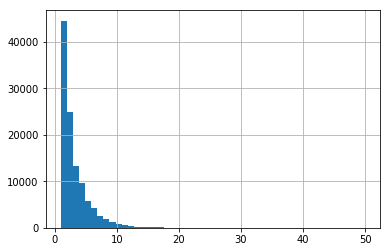

In [12]:
df_freq = gdf1['ViolationAddress'].value_counts()
dfx = df_freq[(df_freq <= 50)]
dfx.hist(bins=50)

## Produce clean data.frame & visualization

In [13]:
gdf1 = gdf1[['TicketIssuedDT', 'ViolationCode', 'FineAmt', 'LateFee', 'JudgmentAmt', 'geometry', 'ViolationStreetNumber', 'ViolationStreetName', 'addressc']]
gdf1.columns = ['v_issue_dt', 'v_code', 'v_fine', 'v_latefee', 'v_judgement', 'geometry', 'v_st_no', 'v_st_ad', 'v_addressc']
gdf1.head(2)

,v_issue_dt,v_code,v_fine,v_latefee,v_judgement,geometry,v_st_no,v_st_ad,v_addressc
0,01/01/38440 12:00:00 AM,22-2-20,$1500.00,$150.00,$1680.00,POINT (-83.09167672099994 42.36318237000006),2566,GRAND,2566 GRAND
1,01/01/38383 12:00:00 AM,22-2-22,$100.00,$10.00,$140.00,POINT (-83.22039357799997 42.42939076200003),19014,ASHTON,19014 ASHTON


In [14]:
for c in ['v_fine','v_latefee','v_judgement']:
    gdf1[c] = gdf1[c].apply(lambda x: float(x.replace('$','')) if type(x) != float else x)
gdf1.describe()

,v_fine,v_latefee,v_judgement,v_st_no
count,305436.000000,307404.000000,305437.000000,307404.000000
mean,360.088261,35.797058,425.146198,10657.678901
std,660.857538,65.886522,726.358644,6496.105869
min,0.000000,0.000000,0.000000,1.000000
25%,125.000000,10.000000,140.000000,4990.000000
50%,250.000000,25.000000,305.000000,10635.000000
75%,250.000000,25.000000,305.000000,15895.000000
max,10000.000000,1000.000000,11030.000000,95926.000000


In [15]:
%time
def f(x):
    d = {}
    d['v_fine'] = x['v_fine'].sum()
    d['v_latefee'] = x['v_latefee'].sum()
    d['v_judgement'] = x['v_judgement'].sum()
    d['v_st_no'] = x['v_st_no'].values[0]
    d['v_st_ad'] = x['v_st_ad'].values[0] 
    d['v_incidents'] = len(x['v_fine'])
    d['geometry'] = x['geometry'].values[0]
    return pd.Series(d, index=['v_fine', 'v_latefee', 'v_judgement', 'v_st_no', 'v_st_ad', 'v_incidents', 'geometry'])

gdf1_agg = gdf1.groupby('v_addressc').apply(f)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [16]:
crs = {'init': 'epsg:4326'}
gdf1_agg = gpd.GeoDataFrame(gdf1_agg.reset_index(), crs=crs, geometry='geometry')

In [17]:
gdf1_agg.to_file(driver = 'ESRI Shapefile', filename= "violations_clean1.shp")

In [18]:
len(gdf1_agg)

110240

In [19]:
gdf1_agg.head()

,v_addressc,v_fine,v_latefee,v_judgement,v_st_no,v_st_ad,v_incidents,geometry
0,1 10TH,3650.0,365.0,4465.0,1,10TH,15,POINT (-83.21632601699997 42.36978620900004)
1,1 ABBOTT,200.0,20.0,250.0,1,ABBOTT,1,POINT (-83.06537073099997 42.32633096800004)
2,1 ADAIR,200.0,20.0,250.0,1,ADAIR,1,POINT (-83.01380421299996 42.34079213600006)
3,1 BRENTWOOD,1000.0,100.0,1130.0,1,BRENTWOOD,1,POINT (-83.04799603699996 42.33168113800008)
4,1 COVINGTON,150.0,15.0,255.0,1,COVINGTON,3,POINT (-83.11265272199995 42.42034484100003)


In [20]:
addresses_ref = set(parcels.addressc)
addresses_inc = set(gdf1_agg.v_addressc)
addresses_com = addresses_ref.intersection(addresses_inc)
addresses_dif = addresses_inc.difference(addresses_ref)
print(len(addresses_ref))
print(len(addresses_inc))
print(len(addresses_com))
print(len(addresses_dif))
u=gdf1_agg[gdf1_agg.v_addressc.isin(addresses_dif)]
print(u.tail(3))
v=gdf1_agg[gdf1_agg.v_addressc.isin(addresses_com)]
print(v.tail(3))


374788
110240
87930
22310
           v_addressc  v_fine  v_latefee  v_judgement  v_st_no   v_st_ad  \
110237     9999 SALEM  1500.0      150.0       1680.0     9999     SALEM   
110238  9999 SEMINOLE   250.0       25.0        305.0     9999  SEMINOLE   
110239    9999 YACAMA  2000.0      200.0       2260.0     9999    YACAMA   

        v_incidents                                      geometry  
110237            1  POINT (-83.28539517599995 42.42050101400008)  
110238            1  POINT (-83.01513352599994 42.38470997800005)  
110239            2  POINT (-83.09717434799995 42.43950765500006)  
              v_addressc  v_fine  v_latefee  v_judgement  v_st_no  \
110211     9997 WOODSIDE  2250.0      225.0       2595.0     9997   
110213     9998 FIELDING  1250.0      125.0       1525.0     9998   
110220  9999 ASBURY PARK    50.0        5.0         85.0     9999   

            v_st_ad  v_incidents                                      geometry  
110211     WOODSIDE            4  POINT

### demolition permits

In [21]:
def my_split_permits(x):
    if type(x) == float:
        return pd.Series(np.nan)
    a = x.strip().split('\n')
    if len(a) == 3:
        street, city, coords = a
        lat, lon = coords.replace('(','').replace(')','').split(',')
        x = Point([float(lon), float(lat)])
        return pd.Series(x) # pd.Series([float(lat), float(lon)])
    else:
        if '(' in a[-1]:
            coords=a[-1]
            lat, lon = coords.replace('(','').replace(')','').split(',')
            x = Point([float(lon), float(lat)])
            return pd.Series(x)
        print(a)
        return pd.Series(np.nan)

def clean_address_permit(x):
    for e in [' E ', ' W ']:
        if e in x:
            return x.strip().replace(e, ' ').replace('  ', ' ')
    return x.strip().replace('  ', ' ')
    
df4 = pd.read_csv('detroit-demolition-permits.tsv', sep='\t')
permits = df4[['SITE_ADDRESS', 'site_location']]
permits['geometry'] = permits.site_location.apply(my_split_permits)
permits['addressc'] = permits.SITE_ADDRESS.apply(clean_address_permit).apply(clean_address)
print(permits.head())

['15860 W GRAND RIVER', 'Detroit, MI']
['15703 W GRAND RIVER', 'Detroit, MI']
['13982 HOUSTON', 'Detroit, MI']
['10803 STRATMANN', 'Detroit, MI']
['15408 WEST PARKWAY', 'Detroit, MI']
['13803 E SEVEN', 'Detroit, MI']
['14241 HOUSTON', 'Detroit, MI']
['8584 MARK', 'Detroit, MI']
['6438 JOHN', 'Detroit, MI']
['10852 STRATMANN', 'Detroit, MI']
['3955 MT', 'Detroit, MI']
['15231 E STATE', 'Detroit, MI']
['4720 THREE', 'Detroit, MI']
['6450 W EDSEL FORD', 'Detroit, MI']
         SITE_ADDRESS                                      site_location  \
0        4331  BARHAM    4331 BARHAM\nDetroit, MI\n(42.394106, -82.9474)   
1     9707  BESSEMORE  9707 BESSEMORE\nDetroit, MI\n(42.395122, -83.0...   
2     5315  BERKSHIRE  5315 BERKSHIRE\nDetroit, MI\n(42.40322, -82.94...   
3  16670  BRINGARD DR  16670 BRINGARD DR\nDetroit, MI\n(42.44664, -82...   
4      1454  BEATRICE  1454 BEATRICE\nDetroit, MI\n(42.276956, -83.14...   

                              geometry        addressc  
0           POIN

In [22]:
permits = permits[['addressc', 'geometry']]
permits.head()

,addressc,geometry
0,4331 BARHAM,POINT (-82.9474 42.394106)
1,9707 BESSEMORE,POINT (-83.005077 42.395122)
2,5315 BERKSHIRE,POINT (-82.946476 42.40322)
3,16670 BRINGARD,POINT (-82.94720700000001 42.44664)
4,1454 BEATRICE,POINT (-83.147536 42.276956)


In [23]:
#gdf1 = gpd.GeoDataFrame(df, geometry='geometry', crs={'init' :'epsg:4326'})

In [24]:
# total number of demolition permits
addresses_perm = set(permits.addressc)
print(len(addresses_perm))

6356


In [25]:
# set demolition to False
parcels['demolition'] = 0

# add permits
parcels['demolition'] = parcels['addressc'].apply(lambda x: 1 if x in addresses_perm else 0)

In [26]:
# sample equal number of non-demolition parcels
parcels_demol   = parcels[parcels.demolition != 0]
parcels_nodemol = parcels[parcels.demolition == 0].sample(len(parcels_demol))
parcels2 = pd.concat([parcels_demol, parcels_nodemol], axis=0)
parcels2.sort_index(inplace=True)

In [27]:
parcels2.head()

,acreage,address,zip_code,taxable_st,taxable_va,zoning,geometry,addressc,demolition
39,2.000,1001 BRUSH,48226,TAXABLE,8394000.0,SD5,POLYGON ((-83.04453280379356 42.33398059872824...,1001 BRUSH,0
40,0.746,126 MONROE,48226,STATUTORY,0.0,B5,POLYGON ((-83.04514465052586 42.33325384336555...,126 MONROE,1
127,0.490,260 WINDER,48201,TAXABLE,614600.0,PD,POLYGON ((-83.05012855154106 42.34198714303812...,260 WINDER,0
329,0.127,245 EDMUND PL,48201,CITY OWNED,0.0,PD,POLYGON ((-83.05290719590982 42.34542036170333...,245 EDMUND PL,1
401,0.120,64 WATSON,48201,TAXABLE,23500.0,PD,"POLYGON ((-83.05510807546662 42.3451682084612,...",64 WATSON,1


## join data

In [28]:
parcels3 = parcels2.set_index('addressc').join(gdf1_agg[['v_incidents', 'v_latefee', 'v_fine', 'v_addressc']].set_index('v_addressc'))
parcels3['v_incidents'] = parcels3['v_incidents'].fillna(0)
parcels3['v_latefee'] = parcels3['v_latefee'].fillna(0)
parcels3['v_fine'] = parcels3['v_fine'].fillna(0)


In [29]:
parcels3.head()

,acreage,address,zip_code,taxable_st,taxable_va,zoning,geometry,demolition,v_incidents,v_latefee,v_fine
10 PARKHURST,0.071,10 E PARKHURST,48203,TAXABLE,200.0,B4,POLYGON ((-83.10165924895793 42.42084542526462...,1,1.0,5.0,50.0
10 PARKHURST,0.112,10 W PARKHURST,48203,TAXABLE,400.0,R1,POLYGON ((-83.10245386625138 42.42138041837602...,1,1.0,5.0,50.0
1000 BALDWIN,0.061,1000 BALDWIN,48214,CITY LAND BANK,0.0,R2,POLYGON ((-82.99940522798532 42.35226948592489...,1,5.0,125.0,1250.0
1000 S DIX,2.597,1000 S DIX,48217,TAXABLE,157800.0,M5,POLYGON ((-83.16146131753501 42.28651073053172...,1,0.0,0.0,0.0
1000 SCOTTEN,5.520,1000 SCOTTEN,48209,BOARD OF EDUCATION,0.0,R2,POLYGON ((-83.08912062680008 42.31656224625116...,1,0.0,0.0,0.0


In [177]:
# super simple decison classifier
np.random.seed(42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
parcels3['is_train'] = np.random.uniform(0, 1, len(parcels3)) <= .8
df_train, df_test = parcels3[parcels3['is_train']==True], parcels3[parcels3['is_train']==False]
print(len(df_train), len(df_test))


9107 2239


In [178]:
features = ['v_incidents']
y_train = df_train['demolition']
y_test  = df_test['demolition']



In [179]:
clf = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=100)
clf.fit(df_train[features], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [180]:
y_pred = clf.predict(df_test[features])

In [181]:
print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)*100}')

Accuracy: 64.0


### Result 1: simple model
Ok, so simply using the number of violations (tickets), we get an accuracy of 66.4% for the predictions

# Step 2 - a better model

In [35]:
# 311 calls

df2 = pd.read_csv('detroit-311.csv')
df2=df2[(df2.lng > -85) & (df2.lat > 40) & (df2.lat < 90) & (df2.lng < -70)]
df2.describe(include='all', percentiles=[.5]).T

,count,unique,top,freq,mean,std,min,50%,max
ticket_id,19679,NaN,NaN,NaN,1.69924e+06,172175,1.1844e+06,1.70523e+06,1.9755e+06
city,19679,1,City of Detroit,19679,NaN,NaN,NaN,NaN,NaN
issue_type,19679,23,Illegal Dumping / Illegal Dump Sites,3584,NaN,NaN,NaN,NaN,NaN
ticket_status,19679,4,Archived,9599,NaN,NaN,NaN,NaN,NaN
issue_description,15216,13660,STORM CALL,95,NaN,NaN,NaN,NaN,NaN
rating,19679,NaN,NaN,NaN,2.69257,0.801273,1,3,19
ticket_closed_date_time,16504,15512,08/05/2015 08:39:31 AM,15,NaN,NaN,NaN,NaN,NaN
acknowledged_at,17656,13209,10/13/2015 03:04:25 PM,18,NaN,NaN,NaN,NaN,NaN
ticket_created_date_time,19679,19654,07/07/2015 11:20:35 AM,2,NaN,NaN,NaN,NaN,NaN
ticket_last_updated_date_time,19679,18582,10/13/2015 03:08:53 PM,16,NaN,NaN,NaN,NaN,NaN


In [36]:
df2.head()
issues = ['Illegal Dumping / Illegal Dump Sites', 
          'Trash Issue - Bulk waste deposited more than 24 hours before designated time',
          'Trash Issue - Improper placement of refuse container between collections/left at curbside',
          'DPW - Debris Removal',
          'Graffiti',
          'Curbside Solid Waste Issue']

trash_311 = df2[df2.issue_type.isin(issues)]
trash_311.head(2)

,ticket_id,city,issue_type,ticket_status,issue_description,rating,ticket_closed_date_time,acknowledged_at,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image
1512,1716414,City of Detroit,Illegal Dumping / Illegal Dump Sites,Closed,NaN,3,07/06/2015 03:35:19 PM,06/17/2015 08:33:54 AM,06/16/2015 02:52:13 PM,07/06/2015 03:35:19 PM,"3101-3199 Chalfonte Street Detroit, MI 48238, USA",42.400757,-83.130966,"(42.4007568359, -83.1309661865)",https://crm.seeclickfix.com/files/issue_images...
1587,1718531,City of Detroit,Illegal Dumping / Illegal Dump Sites,Closed,"Tree branches dumped in front of this vacant, ...",3,07/06/2015 03:36:32 PM,06/17/2015 07:20:21 PM,06/17/2015 03:04:26 PM,07/06/2015 03:36:32 PM,"15508 Mansfield Detroit, Michigan",42.404745,-83.204897,"(42.404745, -83.204897)",NaN


In [37]:
# only use address that are clearly identifiable
def my_split_permits(x):
    if type(x) == float:
        return pd.Series(np.nan)
    a = x.strip().split('\n')
    if len(a) == 3:
        street, city, coords = a
        lat, lon = coords.replace('(','').replace(')','').split(',')
        x = Point([float(lon), float(lat)])
        return pd.Series(x) # pd.Series([float(lat), float(lon)])
    else:
        if '(' in a[-1]:
            coords=a[-1]
            lat, lon = coords.replace('(','').replace(')','').split(',')
            x = Point([float(lon), float(lat)])
            return pd.Series(x)
        print(a)
        return pd.Series(np.nan)

def clean_address_permit(x):
    for e in [' E ', ' W ']:
        if e in x:
            return x.strip().replace(e, ' ').replace('  ', ' ')
    return x.strip().replace('  ', ' ')

def my_split(x):
    street, city, coords = x.split('\n')#some sample fransformation 
    lat, lon = coords.replace('(','').replace(')','').split(',')
    x = Point([float(lon), float(lat)])
    return pd.Series(x) # pd.Series([float(lat), float(lon)])

def my_split_address(x):
    street, city, coords = x.split('\n')#some sample fransformation 
    return pd.Series(street.strip()) # pd.Series([float(lat), float(lon)])

def clean_address(x):
    x = x.strip()
    for e in 'ST,BLVD,RD,AVE,DR,STREET,ROAD,DRIVE,BOULEVARD,AVENUE'.split(','):
        if x.strip().endswith(e):
            return x.replace(f' {e}', '')
    return x   

cnt = 0
def clean_address_311(x):
    global cnt
    x = x.upper()
    
    if 'DETROIT' in x:
        x = x.split('DETROIT')[0]
    x = x.strip()
    if '-' not in x:
        for e in 'ST,BLVD,RD,AVE,DR,STREET,ROAD,DRIVE,BOULEVARD,AVENUE'.split(','):
            if x.strip().endswith(e):
                return x.replace(f' {e}', '')
        return x
    else:
        return 'REMOVE'

trash_311['c_addressc'] = trash_311.address.apply(clean_address_311)
trash_311 = trash_311[trash_311.c_addressc != 'REMOVE']
trash_311.head(2)

,ticket_id,city,issue_type,ticket_status,issue_description,rating,ticket_closed_date_time,acknowledged_at,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,c_addressc
1587,1718531,City of Detroit,Illegal Dumping / Illegal Dump Sites,Closed,"Tree branches dumped in front of this vacant, ...",3,07/06/2015 03:36:32 PM,06/17/2015 07:20:21 PM,06/17/2015 03:04:26 PM,07/06/2015 03:36:32 PM,"15508 Mansfield Detroit, Michigan",42.404745,-83.204897,"(42.404745, -83.204897)",NaN,15508 MANSFIELD
1599,1717948,City of Detroit,Illegal Dumping / Illegal Dump Sites,Closed,Several tires on Van Buren between Evergreen a...,3,07/06/2015 03:35:57 PM,06/17/2015 07:18:55 PM,06/17/2015 11:30:12 AM,07/06/2015 03:35:57 PM,"Van Buren And Evergreen Detroit, Michigan",42.355734,-83.235867,"(42.3557344, -83.2358672)",NaN,VAN BUREN AND EVERGREEN


In [38]:
%time
def f(x):
    d = {}
    d['c_311s'] = len(x)
    return pd.Series(d, index=['c_311s'])

gdf2_agg = trash_311.groupby('c_addressc').apply(lambda x: pd.Series(len(x)))
gdf2_agg.columns = ['c_311s']

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [74]:
parcels4 = parcels3.join(gdf2_agg) #.set_index('v_addressc'))
parcels4['c_311s'] = parcels4['c_311s'].fillna(0)

parcels4['taxable_st'] = parcels4['taxable_st'].astype('category')
parcels4['zoning'] = parcels4['zoning'].astype('category')
parcels4.describe()

,acreage,zip_code,taxable_va,demolition,v_incidents,v_latefee,v_fine,c_311s
count,11346.000000,11346.000000,1.134600e+04,11346.000000,11346.000000,11346.000000,11346.000000,11346.000000
mean,0.178822,48217.157324,7.782655e+03,0.500000,1.195752,46.745655,467.976115,0.007492
std,2.105404,10.673025,1.001161e+05,0.500022,2.414811,137.972875,1386.326780,0.112020
min,0.000000,48200.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.080000,48208.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.096000,48214.000000,2.000000e+02,0.500000,0.000000,0.000000,0.000000,0.000000
75%,0.116000,48227.000000,7.200000e+03,1.000000,2.000000,32.500000,300.000000,0.000000
max,181.015000,48240.000000,8.394000e+06,1.000000,94.000000,3305.000000,33050.000000,5.000000


In [176]:
parcels4.head(2)

,acreage,address,zip_code,taxable_st,taxable_va,zoning,geometry,demolition,v_incidents,v_latefee,v_fine,is_train,c_311s,p100,p500,p1000
10 PARKHURST,0.071,10 E PARKHURST,48203,TAXABLE,200.0,B4,POLYGON ((-83.10165924895793 42.42084542526462...,1,1.0,5.0,50.0,True,0.0,27.0,550,1475
10 PARKHURST,0.112,10 W PARKHURST,48203,TAXABLE,400.0,R1,POLYGON ((-83.10245386625138 42.42138041837602...,1,1.0,5.0,50.0,False,0.0,27.0,550,1475


In [40]:
parcels4.c_311s.value_counts()

0.0    11279
1.0       56
2.0        7
3.0        2
4.0        1
5.0        1
Name: c_311s, dtype: int64

In [41]:
cat_columns = parcels4.select_dtypes(['category']).columns
parcels4b = parcels4.copy(deep=True)
parcels4b[cat_columns] = parcels4b[cat_columns].apply(lambda x: x.cat.codes)

In [94]:
df_train, df_test = parcels4b[parcels4b['is_train']==True], parcels4b[parcels4b['is_train']==False]
print(len(df_train), len(df_test))


9107 2239


In [146]:
features = ['v_incidents', 'acreage', 'zip_code', 'taxable_st', 'taxable_va', 'zoning', 'v_latefee', 'v_fine', 'c_311s']
y_train = df_train['demolition']
y_test  = df_test['demolition']

In [147]:
df_train.head(2)

,acreage,address,zip_code,taxable_st,taxable_va,zoning,geometry,demolition,v_incidents,v_latefee,v_fine,is_train,c_311s,p100,p500,p1000
10 PARKHURST,0.071,10 E PARKHURST,48203,20,200.0,2,POLYGON ((-83.10165924895793 42.42084542526462...,1,1.0,5.0,50.0,True,0.0,27.0,550,1475
1000 BALDWIN,0.061,1000 BALDWIN,48214,3,0.0,13,POLYGON ((-82.99940522798532 42.35226948592489...,1,5.0,125.0,1250.0,True,0.0,3.0,407,855


In [148]:
clf = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=100)
clf.fit(df_train[features], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [149]:
y_pred = clf.predict(df_test[features])

In [150]:
print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)*100}')

Accuracy: 79.10000000000001


### Result 2: more complex model
Including parcel info and 311 calls we get an accuracy of 80.3% for the predictions

### add crime data

In [48]:
df3 = pd.read_csv('detroit-crime.csv')
df3.describe(include='all', percentiles=[.5]).T

,count,unique,top,freq,mean,std,min,50%,max
ROWNUM,119931,NaN,NaN,NaN,59966,34621.2,1,59966,119931
CASEID,119931,NaN,NaN,NaN,1.96065e+06,35231.4,1.61227e+06,1.96074e+06,2.02162e+06
INCINO,119931,114992,0.1,22,NaN,NaN,NaN,NaN,NaN
CATEGORY,119931,50,TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS,29412,NaN,NaN,NaN,NaN,NaN
OFFENSEDESCRIPTION,119923,424,ASSAULT AND BATTERY/SIMPLE ASSAULT,11140,NaN,NaN,NaN,NaN,NaN
STATEOFFENSEFILECLASS,119923,NaN,NaN,NaN,45379.6,34891.1,1000,26001,99009
INCIDENTDATE,119931,323,06/01/2015 12:00:00 AM,496,NaN,NaN,NaN,NaN,NaN
HOUR,119931,NaN,NaN,NaN,12.9119,6.71862,0,14,23
SCA,119160,NaN,NaN,NaN,765.133,752.988,201,711,9999
PRECINCT,119160,NaN,NaN,NaN,7.58,7.47007,2,7,99


In [53]:
from shapely.geometry import Point, Polygon

def my_splitX(x):
    a = x.split('\n')#some sample fransformation
    #if len(a) != 3:
    #    print(a)
    coords = a[-1]
    if len(coords) == 0:
        return pd.Series(np.nan)
    
    try:
        lat, lon = coords.replace('(','').replace(')','').split(',')
    except:
        print(a)
    x = Point([float(lon), float(lat)])
    if float(lat) > 90 or float(lat) < -90:
        return pd.Series(np.nan)
    return pd.Series(x) # pd.Series([float(lat), float(lon)])

df3['geometry'] = df3.LOCATION.apply(my_splitX)
df3 = df3[df3.geometry.notnull()]

#geo = [Point(xy) for xy in zip(df3.LON, df3.LAT)]
gdf3 = gpd.GeoDataFrame(df3, geometry='geometry', crs={'init': 'epsg:4326'})
c_pts = gdf3.to_crs(epsg=32617)

In [75]:
# add buffers around parcels
pm = parcels4.to_crs(epsg=32617)
pm['b100'] = pm.buffer(100)
pm['b500'] = pm.buffer(500)
pm['b1000'] = pm.buffer(1000)

In [76]:
def count_pts(x):
    cnt = 0
    for j, pt in c_pts.iterrows():
        if x.contains(pt.geometry):
            # Then it's a hit! Add it to the list,
            # and drop it so we have less hunting.
            cnt += 1
    return pd.Series(cnt)
            
p100 = gpd.sjoin(c_pts, pm.set_geometry('b100').reset_index(), how='left',op="within").groupby('index').size()
p500 = gpd.sjoin(c_pts, pm.set_geometry('b500').reset_index(), how='left',op="within").groupby('index').size()
p1000 = gpd.sjoin(c_pts, pm.set_geometry('b1000').reset_index(), how='left',op="within").groupby('index').size()

In [77]:
parcels4.head()

,acreage,address,zip_code,taxable_st,taxable_va,zoning,geometry,demolition,v_incidents,v_latefee,v_fine,is_train,c_311s
10 PARKHURST,0.071,10 E PARKHURST,48203,TAXABLE,200.0,B4,POLYGON ((-83.10165924895793 42.42084542526462...,1,1.0,5.0,50.0,True,0.0
10 PARKHURST,0.112,10 W PARKHURST,48203,TAXABLE,400.0,R1,POLYGON ((-83.10245386625138 42.42138041837602...,1,1.0,5.0,50.0,False,0.0
1000 BALDWIN,0.061,1000 BALDWIN,48214,CITY LAND BANK,0.0,R2,POLYGON ((-82.99940522798532 42.35226948592489...,1,5.0,125.0,1250.0,True,0.0
1000 S DIX,2.597,1000 S DIX,48217,TAXABLE,157800.0,M5,POLYGON ((-83.16146131753501 42.28651073053172...,1,0.0,0.0,0.0,True,0.0
1000 SCOTTEN,5.520,1000 SCOTTEN,48209,BOARD OF EDUCATION,0.0,R2,POLYGON ((-83.08912062680008 42.31656224625116...,1,0.0,0.0,0.0,True,1.0


In [78]:
p100.head()

index
10 PARKHURST     27
1000 BALDWIN      3
1000 S DIX        1
1000 SCOTTEN     36
10000 BRAMELL    19
dtype: int64

In [79]:
p500.head()

index
10 PARKHURST     550
1000 BALDWIN     407
1000 S DIX        50
1000 SCOTTEN     371
10000 BRAMELL    184
dtype: int64

In [80]:
p1000.head()

index
10 PARKHURST     1475
1000 BALDWIN      855
1000 S DIX         74
1000 SCOTTEN     1107
10000 BRAMELL     224
dtype: int64

In [81]:
type(p1000)

pandas.core.series.Series

In [82]:
parcels4 = parcels4.merge(p100.rename('p100'), left_index=True, right_index=True, how='outer')
parcels4 = parcels4.merge(p500.rename('p500'), left_index=True, right_index=True, how='outer')
parcels4 = parcels4.merge(p1000.rename('p1000'), left_index=True, right_index=True, how='outer')

In [128]:
parcels4.p100.fillna(0, inplace=True)
parcels4.p500.fillna(0, inplace=True)
parcels4.p1000.fillna(0, inplace=True)
parcels4.head()

,acreage,address,zip_code,taxable_st,taxable_va,zoning,geometry,demolition,v_incidents,v_latefee,v_fine,is_train,c_311s,p100,p500,p1000
10 PARKHURST,0.071,10 E PARKHURST,48203,TAXABLE,200.0,B4,POLYGON ((-83.10165924895793 42.42084542526462...,1,1.0,5.0,50.0,True,0.0,27.0,550,1475
10 PARKHURST,0.112,10 W PARKHURST,48203,TAXABLE,400.0,R1,POLYGON ((-83.10245386625138 42.42138041837602...,1,1.0,5.0,50.0,False,0.0,27.0,550,1475
1000 BALDWIN,0.061,1000 BALDWIN,48214,CITY LAND BANK,0.0,R2,POLYGON ((-82.99940522798532 42.35226948592489...,1,5.0,125.0,1250.0,True,0.0,3.0,407,855
1000 S DIX,2.597,1000 S DIX,48217,TAXABLE,157800.0,M5,POLYGON ((-83.16146131753501 42.28651073053172...,1,0.0,0.0,0.0,True,0.0,1.0,50,74
1000 SCOTTEN,5.520,1000 SCOTTEN,48209,BOARD OF EDUCATION,0.0,R2,POLYGON ((-83.08912062680008 42.31656224625116...,1,0.0,0.0,0.0,True,1.0,36.0,371,1107


In [129]:
cat_columns = parcels4.select_dtypes(['category']).columns
parcels4c = parcels4.copy(deep=True)
parcels4c[cat_columns] = parcels4c[cat_columns].apply(lambda x: x.cat.codes)

In [165]:
df_train, df_test = parcels4c[parcels4c['is_train']==True], parcels4c[parcels4c['is_train']==False]
print(len(df_train), len(df_test))

9107 2239


In [166]:
features = ['v_incidents', 'acreage', 'zip_code', 'taxable_st', 'taxable_va', 
            'zoning', 'v_latefee', 'v_fine', 'c_311s', 'p100', 'p500', 'p1000']
y_train = df_train['demolition']
y_test  = df_test['demolition']

In [167]:
clf = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=100)
clf.fit(df_train[features], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [168]:
y_pred = clf.predict(df_test[features])

In [169]:
print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)*100}')

Accuracy: 81.69999999999999


In [170]:
len(parcels4c)

11346

In [171]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
std

array([0.02821724, 0.0086968 , 0.00752442, 0.05035927, 0.06831578,
       0.00556545, 0.04066733, 0.04143706, 0.0006304 , 0.00743901,
       0.01344514, 0.01678914])

In [172]:
indices = np.argsort(importances)[::-1]
indices

array([ 4, 11, 10,  1,  9,  3,  2,  7,  6,  5,  0,  8])

In [173]:
std[indices]

array([0.06831578, 0.01678914, 0.01344514, 0.0086968 , 0.00743901,
       0.05035927, 0.00752442, 0.04143706, 0.04066733, 0.00556545,
       0.02821724, 0.0006304 ])

In [174]:
importances[indices]

array([0.27914859, 0.12559244, 0.11160369, 0.10779057, 0.07798318,
       0.07229392, 0.06557458, 0.05226263, 0.04933645, 0.03270976,
       0.0247109 , 0.0009933 ])

range(0, 12)


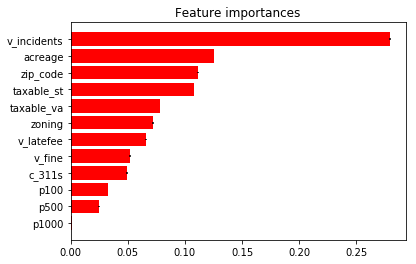

In [175]:
feats = features
print(range(len(feats)))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(12), importances[indices], color="r", yerr=std[indices], align="center")
plt.yticks(range(len(feats)), feats)
plt.ylim([-1, len(feats)])
plt.gca().invert_yaxis()
plt.show()

# add fast.ai tabular

In [280]:
from fastai.tabular import * 

In [282]:
parcels4.head(2)

,acreage,address,zip_code,taxable_st,taxable_va,zoning,geometry,demolition,v_incidents,v_latefee,v_fine,is_train,c_311s
10 PARKHURST,0.071,10 E PARKHURST,48203,TAXABLE,200.0,B4,POLYGON ((-83.10165924895793 42.42084542526462...,1,1.0,5.0,50.0,True,0.0
10 PARKHURST,0.112,10 W PARKHURST,48203,TAXABLE,400.0,R1,POLYGON ((-83.10245386625138 42.42138041837602...,1,1.0,5.0,50.0,False,0.0


In [283]:
procs = [FillMissing, Categorify, Normalize]

In [307]:
dep_var = 'demolition'
cat_names = ['taxable_st', 'zoning', 'zip_code']
cont_names = ['taxable_va', 'v_incidents', 'acreage', 'v_latefee', 'v_fine', 'c_311s']


valid_idx = (parcels4.is_train == 0).values
display(valid_idx)
data = TabularDataBunch.from_df('.', parcels4, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names, cont_names=cont_names)

array([False,  True, False, False, ..., False,  True, False,  True])

In [312]:
learn = tabular_learner(data, layers=[200,100], emb_szs={'taxable_st': 5, 'zoning': 10, 'zip_code': 40},  metrics=accuracy)
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


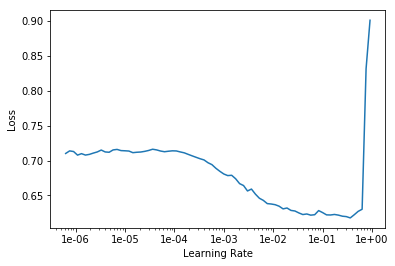

In [313]:
learn.recorder.plot()

In [315]:
learn.fit_one_cycle(8, 4e-2)

epoch,train_loss,valid_loss,accuracy
1,0.392425,1.965225,0.512282
2,0.407288,0.534994,0.750335
3,0.425768,0.712039,0.581510
4,0.406334,1.064310,0.532827
5,0.416862,0.468274,0.765074
6,0.396384,0.661351,0.661456
7,0.382681,1.375534,0.510942
8,0.376455,1.489451,0.513622


In [311]:
learn.show_results(rows=40)

taxable_st,zoning,zip_code,taxable_va,v_incidents,acreage,v_latefee,v_fine,c_311s,target,prediction
TAXABLE,R1,48203,-0.0844,-0.0818,-0.0266,-0.2926,-0.2917,-0.0716,1,1
TAXABLE,R1,48239,0.1257,-0.0818,-0.0212,-0.2582,-0.2575,-0.0716,0,0
CITY LAND BANK,R1,48227,-0.0890,-0.4935,-0.0326,-0.3270,-0.3260,8.8575,1,1
CITY LAND BANK,R2,48204,-0.0890,-0.4935,-0.0474,-0.3270,-0.3260,-0.0716,1,1
TAXABLE,R1,48227,0.0264,-0.4935,-0.0326,-0.3270,-0.3260,-0.0716,0,0
CITY LAND BANK,R1,48224,-0.0890,1.1532,-0.0326,0.5683,0.5647,-0.0716,1,1
CITY LAND BANK,R1,48227,-0.0890,-0.4935,-0.0350,-0.3270,-0.3260,-0.0716,1,1
CITY LAND BANK,R1,48227,-0.0890,-0.0818,-0.0261,-0.2926,-0.2917,-0.0716,1,1
CITY LAND BANK,R1,48227,-0.0890,0.7415,-0.0078,0.3617,0.3592,-0.0716,1,1
CITY LAND BANK,R1,48224,-0.0890,-0.4935,-0.0380,-0.3270,-0.3260,-0.0716,1,0


In [ ]:

feat_violations = ['acreage', 'zip_code', 'taxable_st', 'taxable_va', 'zoning', 'v_incidents']
feat_311 = ['acreage', 'zip_code', 'taxable_st', 'taxable_va', 'zoning', 'v_incidents']



parcels3 = parcels2.set_index('addressc').join(gdf1_agg[[feat_violations + ['v_addressc']].set_index('v_addressc'))
parcels3['v_incidents'] = parcels3['v_incidents'].fillna(0)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
#axes = axes.flatten()

gdf1.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=.75, markersize=.5)
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

ax.set_title('Violations')
fig.savefig('violations.png', dpi=300, bbox_inches = 'tight')

### Aggregate data to street address

In [ ]:
gdf1.groupby('v_addressc').size()
gdf1.head(2)

In [ ]:

# we'll make a string column for the wKT geom
gdf['WKT'] = gdf['geometry'].apply(lambda x: str(x))

grouped_gdf = gdf1.groupby('addressc').count().reset_index()
result_gdf  = grouped_gdf[['WKT', 'your_column']]

# then rebuild geometry from WKT
from shapely.wkt import loads

result_gdf['geometry'] = result_gdf['WKT'].apply(lambda x: loads(x))
result_gdf = geopandas.GeoDataFrame(result_gdf)

## Complaint calls (311)

In [ ]:
df2 = pd.read_csv('detroit-311.csv')
df2.describe(include='all', percentiles=[.5]).T

In [ ]:
df2=df2[(df2.lng > -85) & (df2.lat > 40) & (df2.lat < 90) & (df2.lng < -70)]
df2.describe(include='all', percentiles=[.5]).T

In [ ]:
df = df2.copy(deep=True)
df['geometry'] = df.apply(lambda row: Point(row.lng, row.lat), axis=1)
gdf2 = gpd.GeoDataFrame(df, geometry='geometry', crs={'init' :'epsg:4326'})

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
#axes = axes.flatten()

gdf2.to_crs(epsg=3857).plot(ax=ax, color='orange', alpha=.75, markersize=.5)
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

ax.set_title('311 calls')
fig.savefig('calls.png', dpi=300, bbox_inches = 'tight')

In [ ]:
# remove outliers

## Crime incidents

In [ ]:
df3 = pd.read_csv('detroit-crime.csv')
df3.describe(include='all', percentiles=[.5]).T

In [ ]:
# filter data, this one is pretty bad.... use previous data as boundary
xmin = df2.lng.min()
xmax = df2.lng.max()
ymin = df2.lat.min()
ymax = df2.lat.max()

df3=df3[(df3.LON > xmin) & (df3.LAT > ymin) & (df3.LAT < ymax) & (df3.LON < xmax)]
df3.describe(include='all', percentiles=[.5]).T

In [ ]:
df = df3.copy(deep=True)
df['geometry'] = df.apply(lambda row: Point(row.LON, row.LAT), axis=1)
gdf3 = gpd.GeoDataFrame(df, geometry='geometry', crs={'init' :'epsg:4326'})

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
#axes = axes.flatten()

gdf3.to_crs(epsg=3857).plot(ax=ax, color='purple', alpha=.75, markersize=.5)
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

ax.set_title('Crimes')
fig.savefig('crimes.png', dpi=300, bbox_inches = 'tight')

## Demolition permits

In [103]:
df4 = pd.read_csv('detroit-demolition-permits.tsv', sep='\t')
df4.describe(include='all', percentiles=[.5]).T

,count,unique,top,freq,mean,std,min,50%,max
PERMIT_NO,7133,6412,BLD2011-04046,6,NaN,NaN,NaN,NaN,NaN
PERMIT_APPLIED,7133,780,10/6/12,127,NaN,NaN,NaN,NaN,NaN
PERMIT_ISSUED,7133,783,10/6/12,127,NaN,NaN,NaN,NaN,NaN
PERMIT_EXPIRES,6953,728,8/6/15,803,NaN,NaN,NaN,NaN,NaN
SITE_ADDRESS,7133,6359,17525 WYOMING- MUMFORD HIGH,6,NaN,NaN,NaN,NaN,NaN
BETWEEN1,7091,2546,Between ORMOND and POWELL,58,NaN,NaN,NaN,NaN,NaN
PARCEL_NO,7133,6274,3 611-9,13,NaN,NaN,NaN,NaN,NaN
LOT_NUMBER,7062,1282,SEE,135,NaN,NaN,NaN,NaN,NaN
SUBDIVISION,6087,1594,OAKWOOD (PLATS),251,NaN,NaN,NaN,NaN,NaN
CASE_TYPE,7133,1,BLD,7133,NaN,NaN,NaN,NaN,NaN


In [104]:
df4.BLD_PERMIT_TYPE.value_counts()

DISM         5859
Dismantle    1274
Name: BLD_PERMIT_TYPE, dtype: int64

In [107]:
len(df4)

7133

In [ ]:
df_freq2 = df4['site_location'].value_counts()
len(df_freq2)

In [ ]:
nan_cnt = 0
def my_split2(x):
    global nan_cnt

    if type(x) == float:
        nan_cnt +=1
        return pd.Series(np.nan)

    # print(f'>> {x} <<')

    if len(x.split('\n')) == 1:
        coords = x
    else:
        street, city, coords = x.split('\n')#some sample fransformation 
        
    if len(coords) < 3:
        nan_cnt += 1
        return pd.Series(np.nan)
        
    lat, lon = coords.replace('(','').replace(')','').split(',')
    x = Point([float(lon), float(lat)])
    return pd.Series(x) # pd.Series([float(lat), float(lon)])


df4['geometry'] = df4.site_location.apply(my_split2)

print(f'NaN count: {nan_cnt}')
print('Dropping nan rows')
df4 = df4[pd.notnull(df4['geometry'])]
df4['lon'] = df4.geometry.apply(lambda r: r.x)
df4['lat'] = df4.geometry.apply(lambda r: r.y)

# limit to previous extent
df4=df4[(df4.lon > xmin) & (df4.lat > ymin) & (df4.lat < ymax) & (df4.lon < xmax)]



gdf4 = gpd.GeoDataFrame(df4, geometry='geometry', crs={'init' :'epsg:4326'})
print(len(gdf4))
print(gdf4.geometry.total_bounds)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
#axes = axes.flatten()

gdf4.to_crs(epsg=3857).plot(ax=ax, color='blue', alpha=.75, markersize=.5)
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

ax.set_title('Demolition')
fig.savefig('demolition.png', dpi=300, bbox_inches = 'tight')

## Parcel data

In [ ]:
# convert to geopandas 
gf = gpd.read_file("geo_export_b5018d7d-5276-4925-9cb3-1bbf74026fde.shp")

#gf = gpd.GeoDataFrame(dfb.drop(['lon', 'lat'], axis=1),
#                      crs={'init': 'epsg:4326'},
#                      geometry=[shapely.geometry.Point(xy) for xy in zip(dfb.lon, dfb.lat)])
gf.head(2) #gf = gf.rename(columns={'geometry': 'pickup'})
gf.crs

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
#axes = axes.flatten()

gf.sample(frac=.1).to_crs(epsg=3857).plot(ax=ax, edgecolor='black')
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

ax.set_title('Parcels (1/10 of total)')
fig.savefig('parcels.png', dpi=300, bbox_inches = 'tight')

In [ ]:
dfj = gpd.sjoin(gdf1, gf, how="inner", op='intersects')
dfj.head()

In [ ]:
len(dfj)

In [ ]:
new_df = gpd.sjoin(gf, gdf4, how="inner", op='intersects')
print(len(new_df))
print(len(gf))
print(len(gdf4))

In [ ]:
gf.columns

In [ ]:
x="2566 E GRAND BLVD"

In [ ]:
gf['address'].unique()

In [ ]:
def get_ratio(row):
    name = row['address']
    return fuzz.token_sort_ratio(name, "2566 GRAND BLVD")

gf[gf.apply(get_ratio, axis=1) > 90]

In [ ]:
def get_ratio(row):
    name = row['address']
    return fuzz.token_sort_ratio(name, "19014 ASHTON")

gf[gf.apply(get_ratio, axis=1) > 90]

In [ ]:
gf.describe().T

In [ ]:
# merge 1
